# Marvel Universe: Data Mining

This whole notebook is dedicated to getting the data needed. Using WikiPedia requests, we make a group of Marvel superheroes and supervillains. Since there are some character who are listed as both, we make another group called Ambiguous, which we then will subtract from both superheroes and supervillains. In the end, we would have three distinct groups

## Part 0: Getting the data
### Defining functions:

In [258]:
import requests as rq
import os
import urllib3 

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  # Suppress InsecureRequestWarning
def get_marvel_character_list(character_type):
    """Returns a set of one type of Marvel Characters (either superheroes or supervillains)
    
    Using the rq.get() method, request the WikiPedia page containing the list of either character type
    defined by the user, then store the .json result into a dictionary, with the continue keyword if it 
    exists. In a loop, keys into query and categorymembers to access title, which contains the character
    name to be added into a set, requests another query with the continue key. If there is a KeyError,
    Then there is no more continue data to be keyed into.
    
    Args:
        characters: string describing the type of marvel characters ("superheroes or supervillains")
    Returns: 
        group: a set of the character names

    """
    group = set()  
    
    wpage = r"https://en.wikipedia.org/w/api.php?"
    action = r"action=query"
    format = r"format=json"
    list = r"list=categorymembers"
    title = fr"cmtitle=Category:Marvel_Comics_{character_type}"
    url = wpage + "&".join([action,format,list,title])
    
    data = rq.get(url).json()
    cont = data['continue']['cmcontinue']  # Continue key to be appended with the request
    
    for entry in data['query']['categorymembers']:
        group.add(entry['title'])
    while True:
        try:
            data = rq.get(url + "&cmcontinue=%s" % cont).json()
            cont = data['continue']['cmcontinue']

            for entry in data['query']['categorymembers']:
                group.add(entry['title'])
        except KeyError:
            break
    return group

def make_groups(offline=False):
    """Partitions the three main groups
    
    Defines global variables for each then makes the superheroes and supervillain
    sets. If offline, the markups are already stored on the directory, so to make
    the groups, just make a set of list of files in each directory. Else, forms the 
    superheroes and supervillains from requests (takes long) and  forms the ambiguous 
    set which is the intersection then, subtracts them from each group.
    
    Args:
        offline: a keyword argument specifying if the groups should be made from 
        the existing directory or from requesting. The former is much faster as it
        just accesses the already-stored markups on each of the character folders,
        instead of requesting all over again.
    Returns:
        a tuple of superheroes, supervillains, ambiguous in that order.
    """
    
    def clean_data(data):
        """Cleans the set by removing entries with 'Category' or 'List of'."""
        for item in data.copy():
            if item.find("Category") != -1 or item.find("List of") != -1:
                data.remove(item)
        return data
    
    global superheroes, supervillains, ambiguous
    
    if offline:  # Must have the the stored directory markups for each group already.
        for group, faction in enumerate(['superheroes', 'supervillains', 'ambiguous']):  # Each file has a .txt extension
            faction_chars = [c[:-4] for c in os.listdir('characters/%s' % faction)]      # So splice each until [:-4]
            
            if group == 0:
                superheroes = clean_data(faction_chars)
                print("Success: superheroes loaded from directory ")
                
            elif group == 1:
                supervillains = clean_data(faction_chars)
                print("Success: supervillains loaded from directory ")
            
            elif group == 2:
                ambiguous = clean_data(faction_chars)
                print("Success: ambiguous loaded from directory: ")
    else:          
        superheroes = get_marvel_character_list("superheroes")
        supervillains = get_marvel_character_list("supervillains")
        ambiguous = superheroes.intersection(supervillains)
        superheroes -= ambiguous
        supervillains -= ambiguous
        
        superheroes = clean_data(superheroes)
        supervillains = clean_data(supervillains)
        ambiguous = clean_data(ambiguous)
        
    return superheroes, supervillains, ambiguous

global superheroes, supervillains, ambiguous
superheroes, supervillains, ambiguous = make_groups()


In [256]:
import sys
def print_progress(progress, total, text=""):
    bar_length = 20
    tick = int(round(progress/total,1)*bar_length)
    sys.stdout.write(f"\r[ {(tick * '=') + '>'+ (bar_length - tick) * '-'} ] {text} {progress}/{total}")    
    sys.stdout.flush()

In [255]:
def verify_fname(string):
    """Replaces illegal file name characters in the string to legal ones"""

    if string.find(r'"') != -1:                 # The case that a character has a nickname: asdf "eg" asdf
        string = string.replace(r'"', "",2)     

    if string.find(r'/') != -1:                 # If string has two alternative names: asdf / qwer
        string = string.replace(r'/','or')

    if string.find(r':') != -1:                 # Only for strings with "Category: asdf"
        string = string.replace(r':', ' ')     

    return string 

In [260]:
import os
def download_markups(make=False):
    """Downloads the markup for each character and places them into a directory.
    
    '"""
    
    global superheroes, supervillains, ambiguous
    
    if make:
        path_superheroes = "./characters/superheroes"
        path_supervillains = "./characters/supervillains"
        path_ambiguous = "./characters/ambiguous"

        os.makedirs(path_superheroes)
        os.makedirs(path_supervillains)
        os.makedirs(path_ambiguous)
    
    def get_contents(char):
        """Requests the markup page for one character"""
        
        query = fr'https://en.wikipedia.org/w/api.php?format=json&action=query&titles={char}&prop=revisions&rvprop=content' 
        datum = rq.get(query).json()
        return list(datum['query']['pages'].values())[0]['revisions'][0]['*']

    
    for group, chars in enumerate([superheroes, supervillains, ambiguous]):        
        if group == 0:
            for i, char in enumerate(chars, 1):
                path = fr"./characters/superheroes/{verify_fname(char)}.txt"
                sh = open(path, 'w')
                sh.write(str(get_contents(char).encode('utf-8')))
                
                print_progress(i, len(chars), text="Downloading superhero markup...")
            sh.close()
            print("\nsuperhero markups done\n")
            
        elif group == 1:
            for i, char in enumerate(chars, 1):
                path = fr"./characters/supervillains/{verify_fname(char)}.txt"
                sv = open(path, 'w')
                sv.write(str(get_contents(char).encode('utf-8')))
                
                print_progress(i, len(chars), text="Downloading supervillain markup...")
            sv.close()
            print("\nsupervillain markups done")
                         
        elif group == 2:
            for i, char in enumerate(chars, 1):
                path = fr"./characters/ambiguous/{verify_fname(char)}.txt"
                am = open(path, 'w')
                am.write(str(get_contents(char).encode('utf-8')))
                
                print_progress(i, len(chars), text="Downloading ambiguous markup...")
            print("\nambiguous markups done")
                         
                         
download_markups()

[ ====================> ] Downloading superhero markup... 745/745
superhero markups done

[ ====================> ] Downloading supervillain markup... 1033/1033
supervillain markups done
[ ====================> ] Downloading ambiguous markup... 163/163
ambiguous markups done


### Part 2: Explore data

#### Page lengths

>**Ex. 3.2.1**: Extract the length of the page of each character, and plot the distribution of this variable for each class (heroes/villains/ambiguous). Can you say anything about the popularity of characters in the Marvel universe based on your visualization?

>*Hint: The simplest thing is to make a probability mass function, i.e. a normalized histogram. Use `plt.hist` on a list of page lengths, with the argument `normed=True`. Other distribution plots are fine too, though.*

In [179]:
def get_page_size(character):
    link = "https://en.wikipedia.org/w/api.php?format=json&action=query&titles=%s&prop=revisions&rvprop=size" % character
    data = rq.get(link).json()
    return list(data['query']['pages'].values())[0]['revisions'][0]['size']


In [203]:
def get_page_size2(char):
    for faction in ['superheroes', 'supervillains', 'ambiguous']:
        faction_chars = [c[:4] for c in os.listdir(f'./characters/{faction}')]
        if char in faction_chars:
            break
    
    with open(f"./characters/{faction}/{char}.txt", "r") as f:
        length = len(f.read())
    f.close()
    
    return length
get_page_size2("Eddie Brock")

96196

In [214]:
# Construct a dictionary of char:pagesize for each group
# Takes a long time to finish
hero_size = dict(zip(superheroes, [get_page_size(char) for char in superheroes]))
villain_size = dict(zip(supervillains, [get_page_size(char) for char in supervillains]))
amb_size = dict(zip(ambiguous, [get_page_size(char) for char in ambiguous]))

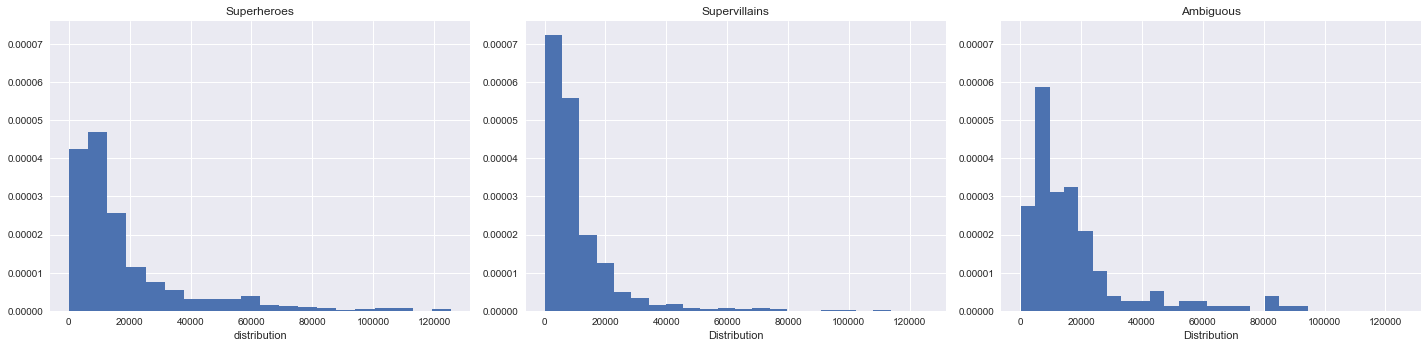

In [218]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

plt.figure(figsize=(20,5))

ax = plt.subplot(1,3,1)
plt.title("Superheroes")
plt.xlabel("distribution")
plt.hist(hero_size.values(), bins=20, density=True)

plt.subplot(1,3,2, sharex=ax, sharey=ax)
plt.title("Supervillains")
plt.xlabel("Distribution")
plt.hist(villain_size.values(), bins=20, density=True)

plt.subplot(1,3,3, sharex=ax, sharey=ax)
plt.title("Ambiguous")
plt.xlabel("Distribution")
plt.hist(amb_size.values(), bins=20, density=True)

plt.tight_layout()
plt.show()

>**Ex. 3.2.2**: Find the 10 characters from each class with the longest Wikipedia pages. Visualize their page lengths with bar charts. Comment on the result.

In [222]:
from collections import OrderedDict

sorted10_amb = OrderedDict(sorted(amb_size.items(), key=lambda x: x[1], reverse=True)[:10])
sorted10_hero = OrderedDict(sorted(hero_size.items(), key=lambda x: x[1], reverse=True)[:10])
sorted10_villain = OrderedDict(sorted(villain_size.items(), key=lambda x: x[1], reverse=True)[:10])


In [233]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


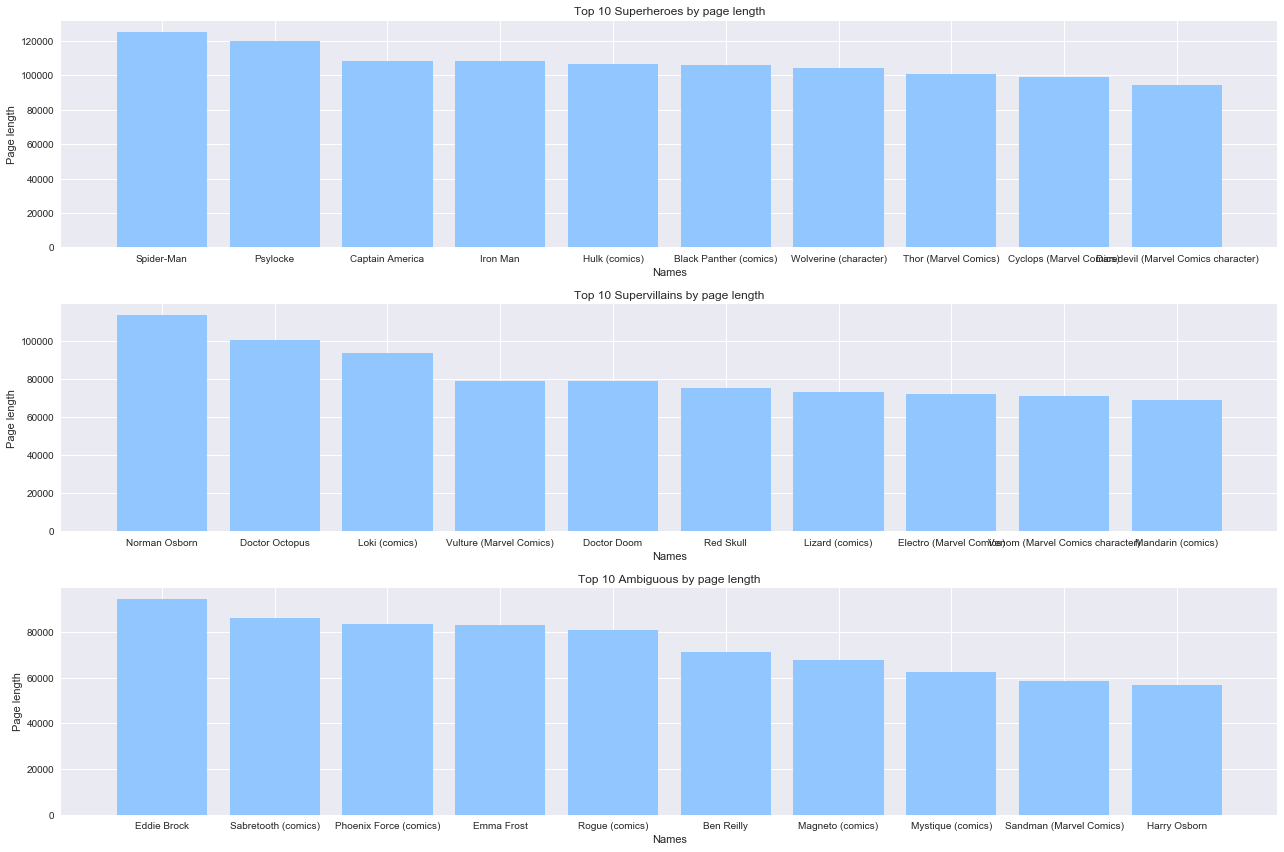

In [236]:
plt.figure(figsize=(18,12))

sns.set("notebook")
plt.style.use("seaborn-pastel")

plt.subplot(3,1,1)
plt.title("Top 10 Superheroes by page length")
plt.xlabel("Names")
plt.ylabel("Page length")
plt.bar(sorted10_hero.keys(), sorted10_hero.values())

plt.subplot(3,1,2)
plt.title("Top 10 Supervillains by page length")
plt.xlabel("Names")
plt.ylabel("Page length")
plt.bar(sorted10_villain.keys(), sorted10_villain.values())

plt.subplot(3,1,3)
plt.title("Top 10 Ambiguous by page length")
plt.xlabel("Names")
plt.ylabel("Page length")
plt.bar(sorted10_amb.keys(), sorted10_amb.values())

plt.tight_layout()
plt.show()

#### Timeline

### **Ex. 3.2.3**: We are interested in knowing if there is a time-trend in the debut of characters.
* Extract into three lists, debut years of heroes, villains, and ambiguous characters.
* Do all pages have a debut year? Do some have multiple? How do you handle these inconsistencies?
* For each class, visualize the amount of characters introduced over time. You choose how you want to visualize this data, but please comment on your choice. Also comment on the outcome of your analysis.

>*Hint: The debut year is given on the debut row in the info table of a character's Wiki-page. There are many ways that you can extract this variable. You should try to have a go at it yourself, but if you are short on time, you can use this horribly ugly regular expression code:*

>*`re.findall(r"\d{4}\)", re.findall(r"debut.+?\n", markup_text)[0])[0][:-1]`*

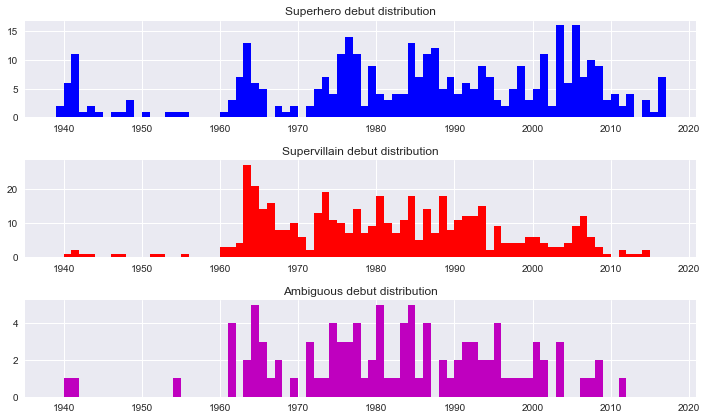

In [251]:
import re
def debut_dates():
    """Gets the debut years and plot the distribution of the characters in each group
    
    """
    
    sh_debuts = []
    sv_debuts = []
    am_debuts = []
    
    def verify_fname(string):
        """Replaces illegal file name characters in the string to blanks"""
        
        if string.find(r'"') != -1:
            string = string.replace(r'"', "",2)
        if string.find(r'/') != -1:
            string = string.replace(r'/','or')
        if string.find(r':') != -1:
            string = string.replace(r':','')
        return string

    def get_debut(char):
        for faction in ['superheroes', 'supervillains','ambiguous']:
            faction_chars = [c[:-4] for c in os.listdir("./characters/%s" % faction)]
            if char in faction_chars:
                break

        with open(r"./characters/%s/%s.txt" % (faction, char), 'r') as f:
            markup = str(f.read())

        try:
            return int(re.findall(r"\d{4}\)", str(re.findall(r"debut.+?\|", markup)))[0][:-1])
        except IndexError:
            return 0
    
        
    for group, faction in enumerate([superheroes, supervillains, ambiguous]):
        if group == 0:
            for char in faction:
                year = get_debut(verify_fname(char))
                
                if year != 0:
                    sh_debuts.append(year)
        elif group == 1:
            for char in faction:                
                year = get_debut(verify_fname(char))
                
                if year != 0:
                    sv_debuts.append(year)
        elif group == 2:
            for char in faction:
                year = get_debut(verify_fname(char))
                
                if year != 0:
                    am_debuts.append(year)
    
    plt.figure(figsize=(10,6))
    
    plt.style.use("seaborn-muted")
    
    ax = plt.subplot(3,1,1)
    plt.title("Superhero debut distribution")
    max_bins = max(sh_debuts) - min(sh_debuts)
    plt.hist(sh_debuts,bins=max_bins,color='b')
    plt.axis('tight')
    
    plt.subplot(312, sharex=ax)
    plt.title("Supervillain debut distribution")
    max_bins = max(sv_debuts) - min(sv_debuts)
    plt.hist(sv_debuts,bins=max_bins,color='r')
    plt.axis('tight')
    
    plt.subplot(313, sharex=ax)
    plt.title("Ambiguous debut distribution")
    max_bins = max(am_debuts) - min(am_debuts)
    plt.hist(am_debuts,bins=max_bins, color='m')
    plt.axis('tight')
    
    plt.tight_layout()
    plt.show()
    
debut_dates()